# Incremental capstone 10: face mask detection

## Notebook set-up

### Imports

In [ ]:
# Standard library imports
import warnings

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms

from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score

### Configuration

In [2]:
# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Define class names
class_names = ['with_mask', 'without_mask']

Using device: cuda


### Hyperparameters

In [3]:
batch_size = 32
learning_rate = 1e-3
epochs = 30
print_every = 5 # Print training progress every n epochs

## 1. Create DataLoaders

In [4]:
# Data preprocessing:
# 1. Convert indexed images to RGB (some are RGBA)
# 2. Resize images to 128x128
# 3. Convert images to tensors
# 4. Normalize images

target_size = (128, 128)

def convert_to_rgb(img):
    '''Convert image to RGB, handling palette images with transparency properly'''
 
    if img.mode == 'P':
        # Convert palette images to RGBA first to handle transparency
        img = img.convert('RGBA')
    
    if img.mode != 'RGB':
        # Then convert to RGB, which will discard the alpha channel
        img = img.convert('RGB')
    
    return img

transform = transforms.Compose([
    transforms.Lambda(convert_to_rgb),
    transforms.Resize(target_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create image dataset
dataset = datasets.ImageFolder(
    root='../data',
    transform=transform
)

print(f'Samples: {len(dataset)}')

Samples: 7553


In [5]:
# Create tensors and preload to GPU
# Note: We suppress the PIL transparency warning here because our convert_to_rgb 
# function already handles it correctly by converting palette images to RGBA first,
# then to RGB. The warning is informational, not an error.
with warnings.catch_warnings():
    
    warnings.filterwarnings('ignore', message='Palette images with Transparency')
    
    X = torch.stack([img for img, _ in dataset]).to(device)
    y = torch.tensor([label for _, label in dataset]).to(device)

print(f'Image tensor shape: {X.shape}')
print(f'Label tensor shape: {y.shape}')

Image tensor shape: torch.Size([7553, 3, 128, 128])
Label tensor shape: torch.Size([7553])


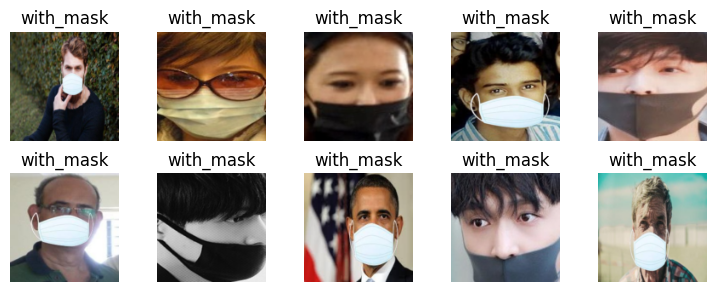

In [6]:
# Plot first 10 RGB images from the training dataset
ncols = 5
nrows = 2

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*1.5, nrows*1.5))
axes = axes.flatten()

for i, ax in enumerate(axes):
    img, label = dataset[i]
    
    # Unnormalize and transpose for plotting
    img = img * 0.5 + 0.5
    img = img.numpy().transpose(1, 2, 0)  # Change from CxHxW to HxWxC
    ax.set_title(class_names[label])
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [7]:
# Split training data into train and validation sets (80/20 split)
n = int(0.8 * len(X))
indices = torch.randperm(len(X))

X_train = X[indices[:n]]
y_train = y[indices[:n]]
X_val = X[indices[n:]]
y_val = y[indices[n:]]

In [8]:
# Create TensorDatasets for train and validation sets
train_tensor_dataset = torch.utils.data.TensorDataset(X_train, y_train)
val_tensor_dataset = torch.utils.data.TensorDataset(X_val, y_val)

# Finally, create DataLoaders
train_loader = DataLoader(train_tensor_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_tensor_dataset, batch_size=batch_size)

print(f'X_train shape: {X_train.shape}')  # Should show 3 channels
print(f'y_train shape: {y_train.shape}')

X_train shape: torch.Size([6042, 3, 128, 128])
y_train shape: torch.Size([6042])


## 2. Build model

In [9]:
model = nn.Sequential(

    # Conv block: RGB input (3 channels)
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.5),
    
    # Classifier
    nn.Flatten(),
    nn.Linear(32 * 64 * 64, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 2)  # Binary classification: 2 outputs for CrossEntropyLoss

).to(device)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(model)
print(f'\nTotal parameters: {trainable_params}')

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.5, inplace=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=131072, out_features=128, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.5, inplace=False)
  (12): Linear(in_features=128, out_features=2, bias=True)
)

Total parameters: 16787874


## 3. Train model

In [10]:
def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    epochs: int = 10,
    print_every: int = 1,
    device: torch.device = None
) -> dict[str, list[float]]:
    '''Training loop for PyTorch classification model.
    
    Args:
        device: If provided, moves batches to this device on-the-fly.
                If None, assumes data is already on the correct device.
    '''

    history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}

    for epoch in range(epochs):

        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            
            # Move batch to device if specified
            if device is not None:
                images, labels = images.to(device), labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Track metrics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate training metrics
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():

            for images, labels in val_loader:
                
                # Move batch to device if specified
                if device is not None:
                    images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total

        # Record metrics
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_accuracy'].append(train_accuracy)
        history['val_accuracy'].append(val_accuracy)

        # Print progress
        if (epoch + 1) % print_every == 0 or epoch == 0:

            print(
                f'Epoch {epoch+1}/{epochs} - ' +
                f'loss: {train_loss:.4f} - ' +
                f'accuracy: {train_accuracy:.2f}% - ' +
                f'val_loss: {val_loss:.4f} - ' +
                f'val_accuracy: {val_accuracy:.2f}%'
            )

    print('\nTraining complete.')

    return history

In [11]:
%%time

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=epochs,
    print_every=print_every
)

Epoch 1/30 - loss: 1.1892 - accuracy: 84.00% - val_loss: 0.2693 - val_accuracy: 87.76%
Epoch 5/30 - loss: 0.2529 - accuracy: 88.70% - val_loss: 0.2285 - val_accuracy: 90.47%
Epoch 10/30 - loss: 0.2018 - accuracy: 90.47% - val_loss: 0.1988 - val_accuracy: 91.13%
Epoch 15/30 - loss: 0.1684 - accuracy: 92.12% - val_loss: 0.1712 - val_accuracy: 93.51%
Epoch 20/30 - loss: 0.1242 - accuracy: 94.01% - val_loss: 0.2631 - val_accuracy: 92.39%
Epoch 25/30 - loss: 0.1195 - accuracy: 94.04% - val_loss: 0.2487 - val_accuracy: 92.85%
Epoch 30/30 - loss: 0.1013 - accuracy: 94.62% - val_loss: 0.2295 - val_accuracy: 92.72%

Training complete.
CPU times: user 1min 51s, sys: 274 ms, total: 1min 51s
Wall time: 1min 51s


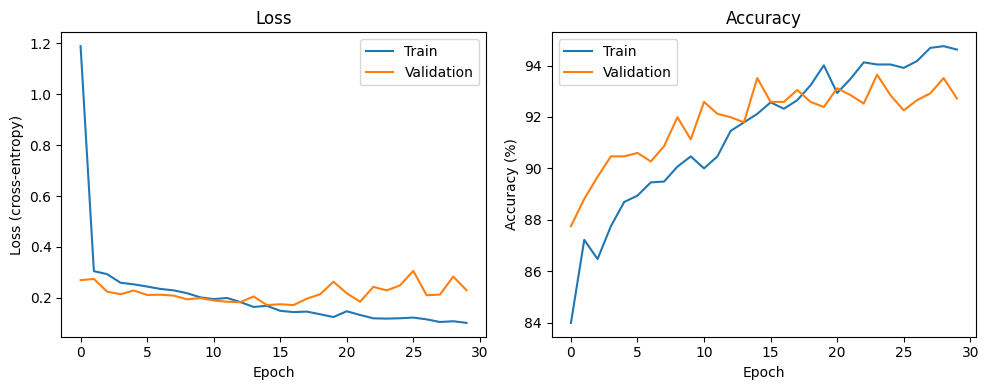

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].set_title('Loss')
axes[0].plot(history['train_loss'], label='Train')
axes[0].plot(history['val_loss'], label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (cross-entropy)')
axes[0].legend(loc='best')

axes[1].set_title('Accuracy')
axes[1].plot(history['train_accuracy'], label='Train')
axes[1].plot(history['val_accuracy'], label='Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].legend(loc='best')

plt.tight_layout()
plt.show()

## 4. Evaluate the model on validation set

In [ ]:
# Get predictions and probabilities for validation set
model.eval()

y_true = []
y_pred = []
y_proba = []

with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_proba.extend(probabilities[:, 1].cpu().numpy())  # Probability of positive class

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_proba = np.array(y_proba)

### Confusion Matrix

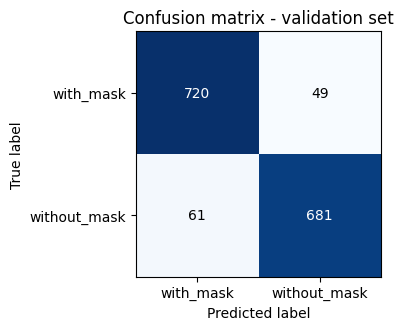

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(4, 4))

ax.set_title('Confusion matrix - validation set')
im = ax.imshow(cm, cmap='Blues')
ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)

# Add text annotations
for i in range(len(class_names)):
    for j in range(len(class_names)):
        text = ax.text(
            j, i, cm[i, j], ha='center', va='center', 
            color='white' if cm[i, j] > cm.max() / 2 else 'black', 
        )

ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

plt.tight_layout()
plt.show()

### ROC and PR Curves

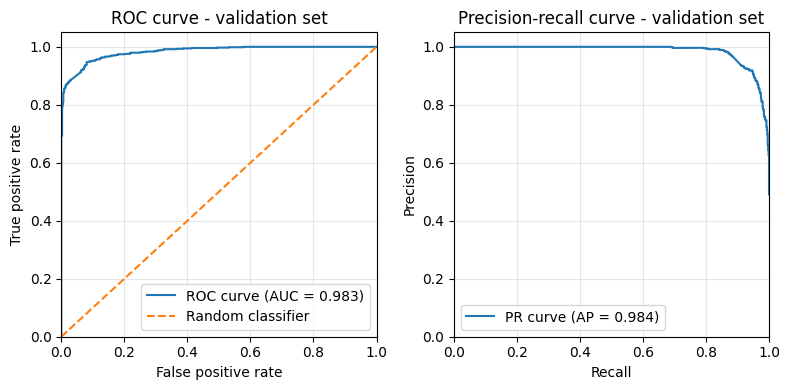

ROC AUC Score: 0.9830
Average Precision Score: 0.9844


In [ ]:
# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_proba)
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve and average precision
precision, recall, _ = precision_recall_curve(y_true, y_proba)
avg_precision = average_precision_score(y_true, y_proba)

# Plot both curves
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# ROC Curve
axes[0].set_title('ROC curve - validation set')
axes[0].plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[0].plot([0, 1], [0, 1], linestyle='--', label='Random classifier')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False positive rate')
axes[0].set_ylabel('True positive rate')
axes[0].legend(loc='lower right')

# Precision-Recall Curve
axes[1].set_title('Precision-recall curve - validation set')
axes[1].plot(
    recall, precision,
    label=f'PR curve (AP = {avg_precision:.3f})'
)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')

plt.tight_layout()
plt.show()

print(f'ROC AUC Score: {roc_auc:.4f}')
print(f'Average Precision Score: {avg_precision:.4f}')